### **1.Importing Libraries**

In [1]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


In [2]:
#!pip install tensorflow

In [3]:
from google.colab import drive
import tensorflow as tf
from tensorflow.keras import layers
from tensorflow.keras.applications import *
from tensorflow.keras.preprocessing.image import ImageDataGenerator
from tensorflow.keras import layers, models
import matplotlib.pyplot as plt
import numpy as np
from sklearn.metrics import confusion_matrix, classification_report
import seaborn as sns
import random
import os

### **2. Loading custom dataset**

In [4]:
root_folder = '/content/drive/MyDrive/brain_dataset_aug'
train_path = '/content/drive/MyDrive/brain_dataset_aug/train'
valid_path = '/content/drive/MyDrive/brain_dataset_aug/valid'
test_path = '/content/drive/MyDrive/brain_dataset_aug/test'

### **3.Data augmentation steps**

In [ ]:
'''
data_augmentation = tf.keras.Sequential([
    layers.experimental.preprocessing.RandomFlip("horizontal"),
    layers.experimental.preprocessing.RandomRotation(0.2),
    layers.experimental.preprocessing.RandomZoom(0.2),
    layers.experimental.preprocessing.RandomContrast(0.2),
])
'''

In [ ]:
'''
train_gen = ImageDataGenerator(
    rescale=1./255,
    rotation_range=20,
    width_shift_range=0.2,
    height_shift_range=0.2,
    shear_range=0.2,
    zoom_range=0.2,
    horizontal_flip=True,
)
'''

### **4.Creating training, validation and test datasets**

In [5]:
batch_size = 50

In [6]:
ds_train = tf.keras.preprocessing.image_dataset_from_directory(
    train_path,
    image_size=(224, 224),
    batch_size=batch_size,
    shuffle=True,
    seed=42,
)

Found 895 files belonging to 2 classes.


In [7]:
#ds_train_augmented = ds_train.map(lambda x, y: (data_augmentation(x, training=True), y))

In [8]:
ds_val = tf.keras.preprocessing.image_dataset_from_directory(
    valid_path,
    seed=1337,
    image_size=(224, 224),
    batch_size=batch_size,
)

Found 37 files belonging to 2 classes.


In [9]:
ds_test = tf.keras.preprocessing.image_dataset_from_directory(
    test_path,
    seed=1337,
    image_size=(224, 224),
    batch_size=batch_size,
)

Found 37 files belonging to 2 classes.


In [10]:
# Checking shape of images
for images, labels in ds_train.take(1):
    print("Image shape:", images[0].shape)

Image shape: (224, 224, 3)


### **5. visualizing images**

In [11]:
def show_random_images(image_dir):
  list_images = random.sample(os.listdir(image_dir), 6)
  list_images = [image_dir + file_name for file_name in list_images]
  i = 0
  rows = 2
  cols = 2
  axes=[]
  fig=plt.figure()

  for a in range(rows*cols):
      axes.append( fig.add_subplot(rows, cols, a+1) )
      axes[-1].set_title(list_images[i].split('/')[4])
      plt.imshow(plt.imread(list_images[i]))
      axes[-1].axis('off')
      i = i + 1
  fig.tight_layout()
  plt.show()

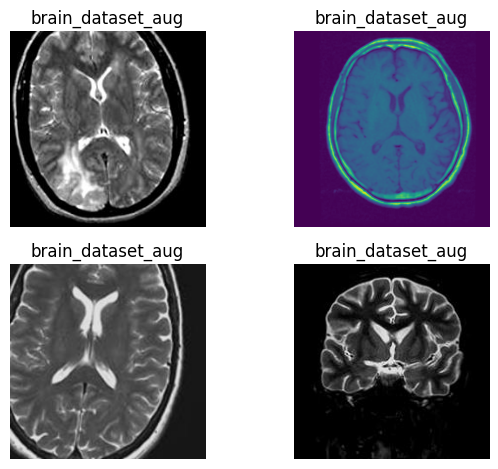

In [12]:
# Visualize non tumoral images
show_random_images('/content/drive/MyDrive/brain_dataset_aug/train/no/')

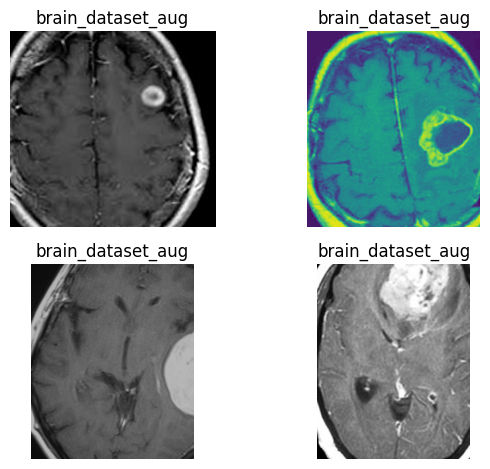

In [13]:
# Visualize tumoral images
show_random_images('/content/drive/MyDrive/brain_dataset_aug/train/yes/')

### **6. Building custom model on top of the pre-trained base model**

In [14]:
# Load pre-trained ConvNeXt without top layers
base_model = NASNetLarge(weights='imagenet', include_top=False, input_shape=(224, 224, 3))

343610240/343610240 [==============================] - 16s 0us/step


In [15]:
# Not Freeze the base model layers
base_model.trainable = True

# Set last 10 layers of the base model to trainable
for  layer in base_model.layers[:-10]:
  layer.trainable = False

In [16]:
num_classes= 2
model = models.Sequential([
    base_model,
    layers.GlobalAveragePooling2D(),
    layers.Dropout(0.5),
    layers.BatchNormalization(),
    layers.Dense(8, activation='softmax')  # num_classes is the number of classes in your dataset
])

### **7. Compiling the model**

In [17]:
model.compile(optimizer='SGD', loss='sparse_categorical_crossentropy', metrics=['accuracy'])

In [18]:
 model.summary()

Model: "sequential"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 NASNet (Functional)         (None, 7, 7, 4032)        84916818  
                                                                 
 global_average_pooling2d (  (None, 4032)              0         
 GlobalAveragePooling2D)                                         
                                                                 
 dropout (Dropout)           (None, 4032)              0         
                                                                 
 batch_normalization (Batch  (None, 4032)              16128     
 Normalization)                                                  
                                                                 
 dense (Dense)               (None, 8)                 32264     
                                                                 
Total params: 84965210 (324.12 MB)
Trainable params: 416

### **8. Training the model**

In [19]:
epochs = 20 # number of epochs
history = model.fit(ds_train, epochs=epochs, validation_data=ds_val)

Epoch 1/20
18/18 [==============================] - 67s 2s/step - loss: 2.2432 - accuracy: 0.3117 - val_loss: 1.9535 - val_accuracy: 0.4324
Epoch 2/20
18/18 [==============================] - 12s 588ms/step - loss: 1.7451 - accuracy: 0.4994 - val_loss: 1.7883 - val_accuracy: 0.5135
Epoch 3/20
18/18 [==============================] - 12s 596ms/step - loss: 1.5445 - accuracy: 0.5821 - val_loss: 1.5123 - val_accuracy: 0.5946
Epoch 4/20
18/18 [==============================] - 12s 605ms/step - loss: 1.3895 - accuracy: 0.6346 - val_loss: 1.3571 - val_accuracy: 0.7297
Epoch 5/20
18/18 [==============================] - 13s 593ms/step - loss: 1.2474 - accuracy: 0.6804 - val_loss: 1.4015 - val_accuracy: 0.7027
Epoch 6/20
18/18 [==============================] - 12s 604ms/step - loss: 1.1597 - accuracy: 0.6994 - val_loss: 1.2748 - val_accuracy: 0.7297
Epoch 7/20
18/18 [==============================] - 12s 598ms/step - loss: 1.0918 - accuracy: 0.7128 - val_loss: 1.5855 - val_accuracy: 0.6216
Ep

### **9. Evaluating the model on the test dataset**

In [20]:
test_loss, test_accuracy = model.evaluate(ds_test)
test_accuracy_percentage = test_accuracy * 100
print(f'Test accuracy: {test_accuracy_percentage:.2f}%')

1/1 [==============================] - 13s 13s/step - loss: 0.4931 - accuracy: 0.7568
Test accuracy: 75.68%


In [21]:
model.save("NASNet.h5")

/usr/local/lib/python3.10/dist-packages/keras/src/engine/training.py:3103: UserWarning: You are saving your model as an HDF5 file via `model.save()`. This file format is considered legacy. We recommend using instead the native Keras format, e.g. `model.save('my_model.keras')`.
  saving_api.save_model(


In [22]:
!cp -r /content/NASNet.h5 /content/drive/MyDrive/SBCAS

### **10.Predicting**

2/2 [==============================] - 9s 1s/step


ValueError: num must be an integer with 1 <= num <= 16, not 17

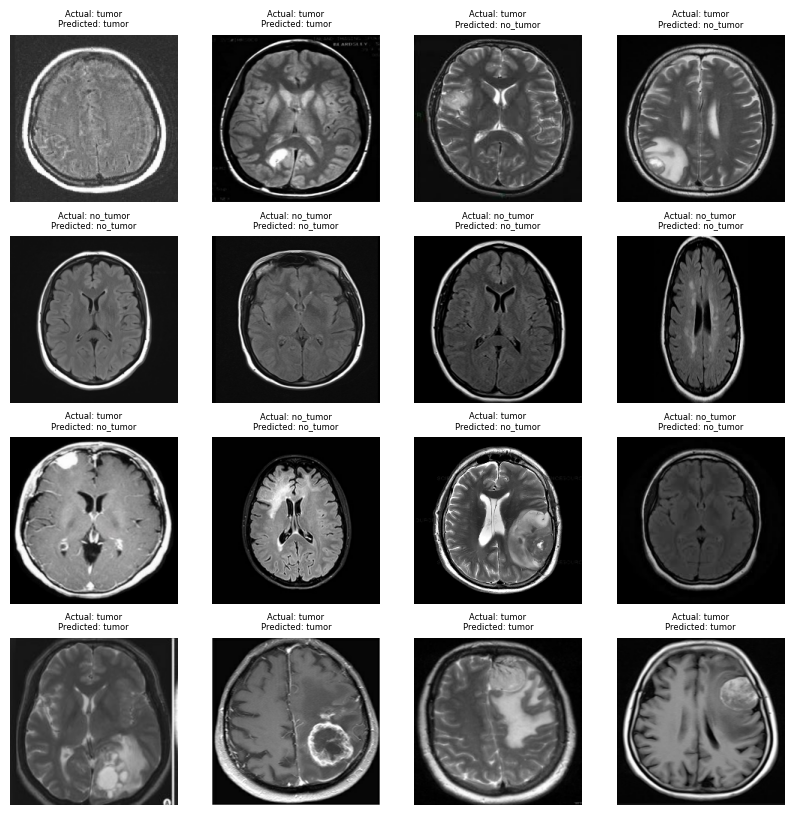

In [23]:
# dataset has 2 classes
class_names = ['no_tumor', 'tumor']
true_labels = []
predicted_labels = []


# Function to print classification report
def print_classification_report(y_true, y_pred, classes):
    report = classification_report(y_true, y_pred, target_names=classes)
    print(report)


# Function to plot confusion matrix
def plot_confusion_matrix(y_true, y_pred, classes):
    cm = confusion_matrix(y_true, y_pred)
    plt.imshow(cm, interpolation='nearest', cmap=plt.cm.Blues)
    plt.title('Confusion Matrix')
    plt.colorbar()
    tick_marks = np.arange(len(classes))
    plt.xticks(tick_marks, classes, rotation=45)
    plt.yticks(tick_marks, classes)

    plt.ylabel('True label')
    plt.xlabel('Predicted label')
    plt.show()


# Function to plot images with actual and predicted class labels
def plot_images(images, labels, predictions=None):
    plt.figure(figsize=(10, 10))
    for i in range(len(images)):
        plt.subplot(4, 4, i + 1)
        plt.imshow(images[i].numpy().astype("uint8"))
        actual_label = class_names[labels[i]]
        if predictions is not None:
            predicted_label = class_names[predictions[i]]
            plt.title(f'Actual: {actual_label}\nPredicted: {predicted_label}', fontsize=6)
        else:
            plt.title(f'Actual: {actual_label}', fontsize=6)
        plt.axis("off")
    plt.subplots_adjust(left=0.1, right=0.9, bottom=0.1, top=0.9, wspace=0.4, hspace=0.4)
    plt.show()


# Get a batch of images and labels from the validation dataset
for images, labels in ds_test.take(1):
    # Make predictions using the model
    true_labels.extend(labels.numpy())
    predictions = model.predict(images)
    predicted_classes = tf.argmax(predictions, axis=1)
    predicted_labels.extend(np.argmax(predictions, axis=1))

    # Plot the images with actual and predicted class labels
    plot_images(images, labels, predicted_classes)


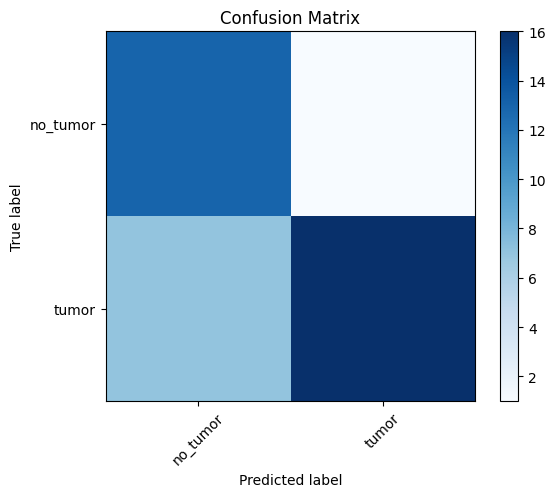

In [24]:
plot_confusion_matrix(true_labels, predicted_labels, class_names)

In [25]:
print_classification_report(true_labels, predicted_labels, class_names)

              precision    recall  f1-score   support

    no_tumor       0.65      0.93      0.76        14
       tumor       0.94      0.70      0.80        23

    accuracy                           0.78        37
   macro avg       0.80      0.81      0.78        37
weighted avg       0.83      0.78      0.79        37

